## import

In [217]:
seed = 42

#from sklearnex import patch_sklearn
#patch_sklearn()

# Import libraries
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(seed)
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import mutual_info_classif, SelectKBest, SelectPercentile, f_classif, f_regression, SelectFromModel
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind
from xgboost import XGBClassifier

from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score

import pickle

## caricamento dati

### caricamento labels pazienti

In [218]:

file_path = "../CSV/data_rad_clin_DEF.csv"

data = pd.read_csv(file_path)
labels_column = data['label']
labels = labels_column.astype(int).tolist()

labels=np.array(labels)

# Estrazione dei numeri dai nomi dei pazienti
loaded_patients = data['IDs_new'].str.extract(r'(\d+)').astype(int).squeeze().tolist()

print("Labels:", labels)
print("Number of labels:", len(labels))
print("Patient Names: ", loaded_patients )




Labels: [0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0
 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0
 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1]
Number of labels: 129
Patient Names:  [5, 12, 15, 16, 17, 19, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 64, 65, 68, 69, 70, 71, 74, 75, 76, 78, 79, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 126, 127, 128, 129, 133, 135, 136, 137, 138, 139, 141, 142, 144, 146, 147, 149, 150, 153, 155, 158, 159, 161, 163, 166, 168, 169, 170, 171, 175, 176, 178, 182, 183, 188, 189, 190, 193, 197, 199, 200, 205]


### caricamento features encoder

In [285]:
#file_path = "../CSV/EncodersSliceMaggiore/VGG19_Slice_Maggiore.csv"
file_path = "../CSV/EncodersSliceMaggiore/InceptionV3_Slice_Maggiore.csv"
#file_path = "../CSV/EncodersSliceMaggiore/RESNET50_Slice_Maggiore.csv"

df = pd.read_csv(file_path, sep=',')


df['Unnamed: 0'] = df['Unnamed: 0'].astype(int)

df_ordered = df.set_index('Unnamed: 0').loc[loaded_patients].reset_index()

df_features = df_ordered.drop(columns=['Unnamed: 0'])

features = df_features.to_numpy()

print(features)
print(features.shape)


[[1.2025036  0.5720962  0.5447646  ... 1.1191139  1.1651635  0.94069195]
 [0.80343825 3.566265   0.6634056  ... 3.4075627  0.         0.03612597]
 [2.1060686  0.7906144  0.82881254 ... 0.7284154  0.39611563 1.2460136 ]
 ...
 [1.6857586  0.71615916 0.         ... 0.         0.03223638 0.38544273]
 [0.77305645 1.3281341  0.         ... 2.4427867  0.         0.1173447 ]
 [0.6291671  3.0247831  1.1139797  ... 1.9223992  0.7866627  1.2099525 ]]
(129, 2048)


### caricamento features radiomica

In [267]:
file_path = "../CSV/EncodersSliceMaggiore/Radiomica_Wavelet_2D.csv"
#file_path = "../CSV/EncodersSliceMaggiore/Radiomica_2D.csv"

df = pd.read_csv(file_path, sep=',')
#df = df.astype(float)

# Colonne da rimuovere SOLO PER RADIOMICA
columns_to_remove = [
    'Slice',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'diagnostics_Image-original_Maximum',
    'diagnostics_Mask-original_VoxelNum',
    'diagnostics_Mask-original_VolumeNum',
]

df_cleaned = df.drop(columns=columns_to_remove)
df_features = df_cleaned.drop(columns=['Paziente'])

features = df_features.to_numpy()

print(features)
print(features.shape)  

[[5.83888273e-01 2.49810487e+01 2.57099203e+01 ... 5.69700030e+03
  5.01293376e-01 1.88681815e+02]
 [8.68120272e-01 2.78353641e+01 2.75136330e+01 ... 1.17856494e+04
  4.99502216e-01 2.32884640e+02]
 [6.68428011e-01 3.34967625e+01 3.44818793e+01 ... 1.10016612e+03
  1.37685835e-01 1.17271924e+02]
 ...
 [8.95387032e-01 3.24479655e+01 2.80178515e+01 ... 3.74357530e+02
  3.76839859e-01 4.56595117e+01]
 [7.82116308e-01 2.65896102e+01 2.56320112e+01 ... 1.71247332e+04
  8.63664634e-01 1.86559244e+02]
 [5.58702485e-01 3.61138047e+01 3.58468967e+01 ... 1.35620356e+04
  4.73861210e-01 2.66695842e+02]]
(129, 474)


### caricamento deep + radiomica

In [152]:
import pandas as pd

# Carica le features della ResNet (o InceptionV3)
#file_path = "../CSV/EncodersSliceMaggiore/RESNET50_Slice_Maggiore.csv"
file_path = "../CSV/EncodersSliceMaggiore/VGG19_Slice_Maggiore.csv"
#file_path = "../CSV/EncodersSliceMaggiore/InceptionV3_Slice_Maggiore.csv"
df_resnet = pd.read_csv(file_path, sep=',')

# Converte la colonna 'Unnamed: 0' in intero
df_resnet['Unnamed: 0'] = df_resnet['Unnamed: 0'].astype(int)

# Filtra per i pazienti caricati
df_resnet_ordered = df_resnet.set_index('Unnamed: 0').loc[loaded_patients].reset_index()

# Rimuovi la colonna di indice
df_resnet_features = df_resnet_ordered.drop(columns=['Unnamed: 0'])

# Carica le features della Radiomica
file_path_radiomica = "../CSV/EncodersSliceMaggiore/Radiomica_Wavelet_2D.csv"
df_radiomica = pd.read_csv(file_path_radiomica, sep=',')

# Colonne da rimuovere per la radiomica
columns_to_remove = [
    'Slice',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'diagnostics_Image-original_Maximum',
    'diagnostics_Mask-original_VoxelNum',
    'diagnostics_Mask-original_VolumeNum',
]

# Pulisci il DataFrame rimuovendo le colonne inutili
df_radiomica_cleaned = df_radiomica.drop(columns=columns_to_remove)

# Rimuovi la colonna 'Paziente' per ottenere solo le feature
df_radiomica_features = df_radiomica_cleaned.drop(columns=['Paziente'])

# Unisci i due DataFrame usando la colonna del paziente come chiave ('Unnamed: 0' per ResNet e 'Paziente' per Radiomica)
df_combined = pd.concat([df_resnet_ordered.set_index('Unnamed: 0'), df_radiomica_cleaned.set_index('Paziente')], axis=1)

# Converti le features in NumPy array
features = df_combined.to_numpy()

# Stampa i risultati
print(features)
print(features.shape)


[[1.06446940e+01 4.26660460e+01 0.00000000e+00 ... 5.69700030e+03
  5.01293376e-01 1.88681815e+02]
 [0.00000000e+00 1.02230230e+02 0.00000000e+00 ... 1.17856494e+04
  4.99502216e-01 2.32884640e+02]
 [9.46728000e-01 2.83576680e+01 0.00000000e+00 ... 1.10016612e+03
  1.37685835e-01 1.17271924e+02]
 ...
 [1.19508160e+01 1.05366940e+01 1.47365430e+01 ... 3.74357530e+02
  3.76839859e-01 4.56595117e+01]
 [0.00000000e+00 1.61865000e+02 0.00000000e+00 ... 1.71247332e+04
  8.63664634e-01 1.86559244e+02]
 [0.00000000e+00 1.29884490e+02 0.00000000e+00 ... 1.35620356e+04
  4.73861210e-01 2.66695842e+02]]
(129, 986)


### caricamento pesi da autoencoder

In [79]:
from tensorflow.keras.models import load_model
import h5py
import cv2

def estrai_immagine_massima_area_con_contorno(imagelist):
    """Restituisce l'immagine con l'area più grande delimitata dal contorno di pixel non neri."""
    max_area = 0
    max_image = None

    for image in imagelist:
        # Crea una maschera per i pixel non neri (placca)
        mask = image > 0
        
        # Converti l'immagine in formato che OpenCV può elaborare
        mask_uint8 = mask.astype(np.uint8) * 255

        # Trova i contorni nell'immagine
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Considera solo il contorno più grande
        if contours:
            # Trova il contorno con la massima area
            largest_contour = max(contours, key=cv2.contourArea)

            # Calcola l'area del contorno
            area = cv2.contourArea(largest_contour)

            # Aggiorna se questa immagine ha un'area maggiore
            if area > max_area:
                max_area = area
                max_image = image

    return max_image

# Caricamento del file HDF5 con le immagini
h5_file_path = '../images_by_patient_final.h5'
loaded_class_images = []

with h5py.File(h5_file_path, 'r') as h5_file:
    for key in h5_file.keys():
        images = np.array(h5_file[key])
        loaded_class_images.append(images)

# Estrai l'immagine con l'area massima per ciascun paziente usando il nuovo criterio (contorno)
immagini_massime_per_paziente_contorno = []

for imagelist in loaded_class_images:
    max_image = estrai_immagine_massima_area_con_contorno(imagelist)
    immagini_massime_per_paziente_contorno.append(max_image)
    

In [83]:
len(immagini_massime_per_paziente_contorno[0][0])

64

In [ ]:


h5_file_path = '../images_by_patient_final.h5'
loaded_class_images=[]

# Apri il file .h5 e carica le immagini in loaded_class_images
with h5py.File(h5_file_path, 'r') as h5_file:
    # Carica ogni gruppo di immagini come un array numpy
    loaded_class_images = {key: np.array(h5_file[key]) for key in h5_file.keys()}

loaded_class_images= {int(key.split('_')[1]): images for key, images in loaded_class_images.items()}

print("Lunghezza array immagini: ", len(loaded_class_images))
print("Shape immagini primo paziente: ", loaded_class_images[0].shape)
print("Shape immagini secondo paziente: ", loaded_class_images[1].shape)

encoder = load_model("../AUTOENCODER/encoder_models/encoder_model32.h5", compile=False)

# Funzione per ottenere le feature da una singola immagine
def get_features_from_image(image):
    image = image.astype('float32')
    image = image / 255.0
    # Ottieni le feature dall'encoder
    if len(image.shape) == 2:  # Se l'immagine è 64x64
        image = np.expand_dims(image, axis=-1)  # Aggiungi canale (per immagini in bianco e nero)
    image = np.expand_dims(image, axis=0)  # Aggiungi dimensione batch
    features = encoder.predict(image, verbose=False)
    features = np.squeeze(features)
    return np.array(features)

# Lista per salvare le feature delle immagini
patients = []

# Ottieni le feature per ogni immagine nella lista
for i in range(len(loaded_class_images)):
    features_list = []
    for img in loaded_class_images[i]:
        features = get_features_from_image(img)
        features_list.append(features)
    fetures_list = np.array(features_list)
    patients.append(features_list)

In [ ]:
import h5py
import cv2

def estrai_immagine_massima_area_con_contorno(imagelist):
    """Restituisce l'immagine con l'area più grande delimitata dal contorno di pixel non neri."""
    max_area = 0
    max_image = None

    for image in imagelist:
        # Crea una maschera per i pixel non neri (placca)
        mask = image > 0
        
        # Converti l'immagine in formato che OpenCV può elaborare
        mask_uint8 = mask.astype(np.uint8) * 255

        # Trova i contorni nell'immagine
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Considera solo il contorno più grande
        if contours:
            # Trova il contorno con la massima area
            largest_contour = max(contours, key=cv2.contourArea)

            # Calcola l'area del contorno
            area = cv2.contourArea(largest_contour)

            # Aggiorna se questa immagine ha un'area maggiore
            if area > max_area:
                max_area = area
                max_image = image

    return max_image

# Caricamento del file HDF5 con le immagini
h5_file_path = 'images_by_patient_final.h5'
loaded_class_images = []

with h5py.File(h5_file_path, 'r') as h5_file:
    for key in h5_file.keys():
        images = np.array(h5_file[key])
        loaded_class_images.append(images)

# Estrai l'immagine con l'area massima per ciascun paziente usando il nuovo criterio (contorno)
immagini_massime_per_paziente_contorno = []
aree_contorno = []

for imagelist in loaded_class_images:
    max_image, max_area = estrai_immagine_massima_area_con_contorno(imagelist)
    immagini_massime_per_paziente_contorno.append(max_image)
    aree_contorno.append(max_area)

# Calcola anche l'area utilizzando solo i pixel non neri (come facevi prima)
aree_non_nere = []
for imagelist in loaded_class_images:
    max_image = estrai_immagine_massima_area(imagelist)
    non_black_pixels = np.sum(max_image != 0)
    aree_non_nere.append(non_black_pixels)

# Visualizza i risultati
print("Numero di immagini selezionate (una per paziente):", len(immagini_massime_per_paziente_contorno))
print("Shape dell'immagine selezionata per il primo paziente (contorno):", immagini_massime_per_paziente_contorno[0].shape)

# Differenza tra area massimizzata col contorno e solo pixel non neri
differenze_tra_insiemi = np.array(aree_contorno) - np.array(aree_non_nere)

# Visualizza la differenza di aree tra il nuovo metodo e il precedente
for i, diff in enumerate(differenze_tra_insiemi):
    print(f"Diff. area paziente {i+1}: {diff}")


## funzioni

In [4]:

## Rimozione feature correlation
def remove_highly_correlated_features(X, threshold=0.85):
    corr_matrix = np.corrcoef(X, rowvar=False)
    upper_triangle = np.triu(corr_matrix, k=1)
    to_drop = [column for column in range(upper_triangle.shape[0]) if any(abs(upper_triangle[column, :]) > threshold)]
    X_reduced = np.delete(X, to_drop, axis=1)
    return X_reduced, to_drop

## Rimozione features p_value
def remove_high_pvalue_features(X, y, alpha=0.05):
    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(X, y)
    p_values = selector.pvalues_
    features_to_keep = np.where(p_values < alpha)[0]
    X_reduced = X[:, features_to_keep]
    return X_reduced, features_to_keep

## FEATURE SELECTION LASSO
def select_features_with_lasso(X, y, alpha=0.001):
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefficients = lasso.coef_
    selected_features = np.where(coefficients != 0)[0]
    X_selected = X[:, selected_features]

    return X_selected, selected_features

## FEATURE SELECTION LOGISTIC
def logistic_regression_feature_selection(X, y, num_features):
    lr = LogisticRegression(max_iter=2000, random_state=42)
    lr.fit(X, y)
    coef_abs = np.abs(lr.coef_)
    feature_importances = np.mean(coef_abs, axis=0)
    selected_features = feature_importances.argsort()[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FEATURE SELECTION MRMR
def mrmr_feature_selection(X, y, num_features):
    mi = mutual_info_classif(X, y, random_state=42)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    distances = squareform(pdist(X_scaled.T, 'euclidean'))
    
    selected_features = []
    selected_indices = []

    first_feature_index = np.argmax(mi)
    selected_features.append(first_feature_index)
    selected_indices.append(first_feature_index)
    
    for _ in range(num_features - 1):
        max_relevance = -np.inf
        selected_feature_index = -1
        
        for i in range(X.shape[1]):
            if i in selected_indices:
                continue
            
            relevance = mi[i]
            redundancy = np.mean(distances[i, selected_indices])
            
            mrmr_score = relevance - redundancy
            
            if mrmr_score > max_relevance:
                max_relevance = mrmr_score
                selected_feature_index = i
        
        selected_features.append(selected_feature_index)
        selected_indices.append(selected_feature_index)

    X_selected = X[:, selected_indices]
    return X_selected, selected_indices

## FEATURE SELECTION RANDOM FOREST
def rf_feature_selection(X, y, num_features):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    feature_importances = rf.feature_importances_
    selected_features = np.argsort(feature_importances)[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features


## FEATURE SELECTION P_VALUE
# Seleziona e ordina le feature basate sui p-value con un test t di Student poi 
# ordina le feature in base al p-value in ordine crescente e seleziona le prime `num_features` caratteristiche.

def select_features_by_p_value(x_train_expanded, y_train_expanded, num_features):
    p_values = []
    num_features_total = x_train_expanded.shape[1]

    # Calcolo dei p-value per ciascuna feature
    for i in range(num_features_total):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)


    p_values = np.array(p_values)

    # Ordinare tutte le caratteristiche in base ai p-value (dal più piccolo al più grande)
    sorted_indices = np.argsort(p_values)
    sorted_indices = sorted_indices[:num_features]

    x_train_selected = x_train_expanded[:, sorted_indices]

    return x_train_selected, sorted_indices



## FUNZIONE PER RIMUOVERE FEATURES SELEZIONATE
def filter_patients_features(filtered_patients, selected_features):
    filtered_patients_selected = []

    for patient_features in filtered_patients:
        # Select only the features specified in selected_features
        patient_features_selected = patient_features[:, selected_features]
        filtered_patients_selected.append(patient_features_selected)

    return filtered_patients_selected


In [5]:
## classificazione completa che ritorna la threshold migliore per la classificazione
def classification_method(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, mode="selector", selected_features=[0], thresholds=np.arange(0.4, 0.6, 0.01)):
    best_f1_score = 0
    best_case = None

    if mode == "selector":
        selected_features = None 

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                if(len(selected_features)==0):
                    return 0
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test

        number_features = len(selected_features)  # Numero di feature selezionate
        #print("Ho scelto le features: ", selected_features)

        # Training del classificatore
        classifier.fit(X_selected, y_train_expanded)

    elif mode == "features":  # Non fa feature selection ma usa le selected_features passate
        if selected_features is None or len(selected_features) == 0:
            print("Error: selected_features must be provided in 'features' mode.")
            return
        
        #print("Testo sulle features:  ", selected_features)
        # Usa solo le selected features su train e test
        X_selected = x_train_expanded[:, selected_features]
        x_test = x_test[:, selected_features]

        number_features = len(selected_features)

        # Training del classificatore su train + validation
        classifier.fit(X_selected, y_train_expanded)
    
    else:
           print("Errore, scegliere tra: selector / features")

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

    if(isinstance(thresholds, np.ndarray)== False): ## se la threshold viene data fissa
        thresholds=[thresholds]
        
    
    for threshold in thresholds:

            y_pred_custom_test = (y_proba_test >= threshold).astype(int)

            accuracy = accuracy_score(y_test, y_pred_custom_test)
            f1 = f1_score(y_test, y_pred_custom_test)
            roc_auc = roc_auc_score(y_test, y_proba_test)

            precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
            pr_auc = auc(recall, precision)

            conf = confusion_matrix(y_test, y_pred_custom_test)
            
            bal_acc = balanced_accuracy_score(y_test, y_pred_custom_test)


            # Se il nuovo risultato è migliore rispetto al migliore attuale (in base all'f1 e altrimenti pr_auc)
            if f1 > best_f1_score or (f1 == best_f1_score and pr_auc > (best_case['pr_auc'] if best_case else 0)):
                best_f1_score = f1
                best_case = {
                    'alpha': alpha,
                    'num_features': number_features,
                    'selected_features': selected_features,
                    'pr_auc': pr_auc,
                    'roc_auc': roc_auc,
                    'f1': f1,
                    'accuracy': accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': threshold,
                    'balanced accuracy': bal_acc
                }

    return best_case


#####################################################################################################################################

### questo ritorna le il vettore di probabilità senza fare la classificazione
def classification_method_withoutThreshold(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, mode="Val", selected_features=[0]):

    if mode == "Val":
        selected_features = None 

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                if (len(selected_features)==0):
                    return [0],0,[0]
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test
        else:
            X_selected = x_train_expanded
            selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection

        number_features = len(selected_features)  # Numero di feature selezionate

        # Training del classificatore
        classifier.fit(X_selected, y_train_expanded)


    if (mode == "Test"): ## non addestra il classificatore e non fa feature selection
        x_test = x_test[:, selected_features]
        number_features = len(selected_features)
    

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

 
    return y_proba_test, number_features, selected_features


#####################################################################################################################################


### classificazione effettuata con una threshold specifica
def classification_threshold(y_proba_test,y_test, threshold, alpha, number_features, selected_features):
        
            best_case = None

            y_pred_custom_test = (y_proba_test >= threshold).astype(int)
            accuracy = accuracy_score(y_test, y_pred_custom_test)
            f1 = f1_score(y_test, y_pred_custom_test)
            roc_auc = roc_auc_score(y_test, y_proba_test)

            precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
            pr_auc = auc(recall, precision)
            bal_acc = balanced_accuracy_score(y_test, y_pred_custom_test)

            conf = confusion_matrix(y_test, y_pred_custom_test)
            best_case = {
                    'alpha': alpha,
                    'num_features': number_features,
                    'selected_features': selected_features,
                    'pr_auc': pr_auc,
                    'roc_auc': roc_auc,
                    'f1': f1,
                    'accuracy': accuracy,
                    'confusion_matrix': conf,
                    'threshold': threshold,
                    'balanced accuracy': bal_acc
                }
                
            if not best_case:
                 print("Attenzione caso vuoto") 
            return best_case

#####################################################################################################################################


# metodo che definisce la threshold ottimale attraverso Youden's J statistic (threshold_selection= 'y')
# oppure attraverso la distanza euclidea dalla curva ROC (threshold_selection= 'd')
def classification_method_selection(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, threshold_selection, mode="Val", selected_features=[0]):
    best_case = None

    if mode == "Val":
        selected_features = None 

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                if(len(selected_features)==0):
                    return 0
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test
        else:
            X_selected = x_train_expanded
            selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection

        number_features = len(selected_features)  # Numero di feature selezionate

        classi=classifierinitialization(classifier, X_selected, y_train_expanded )
        # Training del classificatore
        classi.fit(X_selected, y_train_expanded)


    if (mode == "Test"): ## non addestra il classificatore e non fa feature selection
        x_test = x_test[:, selected_features]
        number_features = len(selected_features)
    

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_proba_test)
    precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
    pr_auc = auc(recall, precision)
        
    fpr,tpr,threshold=roc_curve(y_test,y_proba_test,pos_label=1)
    youden_j = tpr - fpr
    optimal_threshold = threshold[np.argmax(youden_j)]

    ## due modalità 
    if threshold_selection == 'y':
        youden_j = tpr - fpr
        optimal_threshold = threshold[np.argmax(youden_j)]
    elif threshold_selection == 'd':
        distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)
        optimal_threshold = threshold[np.argmin(distances)]
    else:
        print('Threshold non valida!')
        return None

    
    y_pred_custom_test = (y_proba_test >= optimal_threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred_custom_test)
    f1 = f1_score(y_test, y_pred_custom_test)
    conf = confusion_matrix(y_test, y_pred_custom_test)


    best_case = {
        'alpha': alpha,
        'num_features': number_features,
        'selected_features': selected_features,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'f1': f1,
        'accuracy': accuracy,
        'confusion_matrix': conf,
        'best_threshold': optimal_threshold,
        'threshold_mode': threshold_selection
    }

    return best_case

def classifierinitialization(classifier):
    if classifier == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif classifier == 'Logistic':
                            classi = LogisticRegression(random_state=42, max_iter=2000)
    elif classifier == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif classifier == 'XgBoost':
                            classi = XGBClassifier(random_state=42)
    elif classifier == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation = 'logistic')
    elif classifier == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42, max_iter=2000)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'
                                )
    return classi

## split

In [286]:
Y_train, y_test, X_train, X_test= train_test_split(labels, features, test_size=0.3, shuffle=False)


print("Number of train patients: ", len(X_train))
print("Number of test patients: ", len(y_test))

print("Number of features for every image: ", X_train[0].shape[0] )


Number of train patients:  90
Number of test patients:  39
Number of features for every image:  2048


## correlation e p_value

In [287]:

## FEATURE CORRELATION

X_train_reduced, dropped_features = remove_highly_correlated_features(X_train, 0.9)
X_test_reduced = np.delete(X_test, dropped_features, axis=1)


print(X_train_reduced.shape)
print(X_test_reduced.shape)


# RIMOZIONE FEATURES CON P_VALUE ELEVATO

X_train_reduced, features_to_keep = remove_high_pvalue_features(X_train_reduced, Y_train, alpha=0.05)
X_test_reduced = X_test_reduced[:, features_to_keep]

print(X_train_reduced.shape)
print(X_test_reduced.shape)



(90, 2016)
(39, 2016)
(90, 348)
(39, 348)


## parametri

In [288]:
alpha_res_inc = np.linspace(0.01, 0.6, 30).tolist() ## RANGE PER RESNET e INCEPETION

alpha_vgg = np.linspace(0.005, 0.5, 30).tolist() ## RANGE PER VGG

alpha_rad = np.linspace(0.001, 0.05, 30).tolist() ## range per radiomica

######################################
alpha_rad_new = np.linspace(0.0008, 0.1, 50).tolist() ## range per radiomica

alpha_vgg_new = np.linspace(1, 8, 40).tolist() ## RANGE PER VGG

alpha_inc_new = np.linspace(0.055, 0.41, 30).tolist() ## RANGE INCEPETION

alpha_res_new = np.linspace(0.1, 0.5, 30).tolist() ## RANGE resnet


alpha_values=alpha_inc_new
#alpha_values.remove(0.0)


#thresholds=np.arange(0.4, 0.61, 0.01) 

thresholds=[0.5]

#selectors=['lasso', 'mrmr','rf', 'logistic']

classifiers=['XgBoost',  'SVM', 'ensemble','RandomForest', 'Logistic', 'MLP']
#classifiers=['SVM', 'ensemble','RandomForest', 'Logistic']
selectors=['mrmr','rf', 'logistic', 'lasso']



## Loop per Validation seed SPECIFICI

In [289]:

template_dict = {
                'fold': None,
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'selected_features': [],
                'balanced accuracy': None
            }


results_val_others = [template_dict.copy() for _ in range(5000)]
results_val_others.append(template_dict.copy())

results_val_lasso = [template_dict.copy() for _ in range(5000)]
results_val_lasso.append(template_dict.copy())

results_test_others = [template_dict.copy() for _ in range(5000)]
results_test_others.append(template_dict.copy())

results_test_lasso = [template_dict.copy() for _ in range(5000)]
results_test_lasso.append(template_dict.copy())
limit=30

smote = SMOTE(random_state=10)
 
k=0
u=0
n_folds=5

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=4)




### Selezione con selector fisso e numero di features fisse

In [290]:
for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train_reduced, Y_train)):
    print("Starting with fold:", fold_idx)

    x_train_reduced, X_val_reduced = X_train_reduced[train_index], X_train_reduced[val_index]
    y_train, y_val = Y_train[train_index], Y_train[val_index]

    x_train_reduced, y_train = smote.fit_resample(x_train_reduced, y_train)

    #X_train_reduced, Y_train = smote.fit_resample(X_train_reduced, Y_train)


    for i, classifier in enumerate(classifiers):
            print("Starting with classifier:", classifier)
            for j, selector in enumerate(selectors):
                print("Starting with selector:", selector)

                if(selector=='lasso'):

                    for alpha in alpha_values:
                        #print("Doing alpha ", alpha )
                        classi= classifierinitialization(classifier)
                        best_case_val= classification_method(selector, classi, alpha, x_train_reduced, y_train, X_val_reduced, y_val, 0, mode="selector", selected_features=[0], thresholds=0.5)
                        
                        if(best_case_val==0 or best_case_val['num_features']> limit):
                            best_case_val=template_dict
                            best_case_val['balanced accuracy'] = 0
                            best_case_val['accuracy'] = 0
                            best_case_val['f1'] = 0
                            best_case_val['roc_auc'] = 0
                            best_case_val['pr_auc'] = 0
                            best_case_val['selected_features'] = [0]
                            best_case_val['num_features'] = 0
                            best_case_val['confusion_matrix'] = 0
                            
                        #print(f"for {alpha} found {best_case_val['num_features'] }")
                        results_val_lasso[k] = {
                                            'fold': fold_idx,
                                            'classifier': classifier,
                                            'selector': selector,
                                            'alpha': alpha,
                                            'num_features': best_case_val['num_features'],
                                            'selected_features': best_case_val['selected_features'],
                                            'pr_auc': best_case_val['pr_auc'],
                                            'roc_auc': best_case_val['roc_auc'],
                                            'f1': best_case_val['f1'],
                                            'accuracy': best_case_val['accuracy'],
                                            'confusion_matrix': best_case_val['confusion_matrix'],
                                            'balanced accuracy': best_case_val['balanced accuracy'],
                                            }

                        #print(best_case_val['num_features'])
                        

                        if(fold_idx==0):
                            classi= classifierinitialization(classifier)
                            best_case_test= classification_method(selector, classi, alpha, X_train_reduced, Y_train, X_test_reduced, y_test, 0, mode="selector", selected_features=[0], thresholds=0.5)

                            if(best_case_test==0 or best_case_test['num_features']> limit):
                                best_case_test=template_dict
                                best_case_test['balanced accuracy'] = 0
                                best_case_test['accuracy'] = 0
                                best_case_test['f1'] = 0
                                best_case_test['roc_auc'] = 0
                                best_case_test['pr_auc'] = 0
                                best_case_test['selected_features'] = [0]
                                best_case_test['num_features'] = 0
                                best_case_test['confusion_matrix'] = 0
                            
                            results_test_lasso[u] = {
                                                'classifier': classifier,
                                                'selector': selector,
                                                'alpha': alpha,
                                                'num_features': best_case_test['num_features'],
                                                'selected_features': best_case_test['selected_features'],
                                                'pr_auc': best_case_test['pr_auc'],
                                                'roc_auc': best_case_test['roc_auc'],
                                                'f1': best_case_test['f1'],
                                                'accuracy': best_case_test['accuracy'],
                                                'confusion_matrix': best_case_test['confusion_matrix'],
                                                'balanced accuracy': best_case_test['balanced accuracy'],
                                                }
                            u=u+1
                        k = k + 1

                else:
                    #limit=len(x_train_reduced[0]) + 1
                    limit=30
                    for t in range(1, limit):
                            classi= classifierinitialization(classifier)

                            best_case_val= classification_method(selector, classi, 0, x_train_reduced, y_train, X_val_reduced, y_val, t, mode="selector", selected_features=[0], thresholds=0.5)
                    
                                
                            results_val_others[k] = {
                                                'fold': fold_idx,
                                                'classifier': classifier,
                                                'selector': selector,
                                                'alpha': 0,
                                                'num_features': t,
                                                'selected_features': best_case_val['selected_features'],
                                                'pr_auc': best_case_val['pr_auc'],
                                                'roc_auc': best_case_val['roc_auc'],
                                                'f1': best_case_val['f1'],
                                                'accuracy': best_case_val['accuracy'],
                                                'confusion_matrix': best_case_val['confusion_matrix'],
                                                'balanced accuracy': best_case_val['balanced accuracy'],
                                                }
                            #print(results_val_others[k]['f1'])

                            if(fold_idx==0):
                                classi= classifierinitialization(classifier)
                                best_case_test= classification_method(selector, classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, t, mode="selector", selected_features=[0], thresholds=0.5)
                                
                                results_test_others[u] = {
                                                    'classifier': classifier,
                                                    'selector': selector,
                                                    'alpha': 0,
                                                    'num_features': t,
                                                    'selected_features': best_case_test['selected_features'],
                                                    'pr_auc': best_case_test['pr_auc'],
                                                    'roc_auc': best_case_test['roc_auc'],
                                                    'f1': best_case_test['f1'],
                                                    'accuracy': best_case_test['accuracy'],
                                                    'confusion_matrix': best_case_test['confusion_matrix'],
                                                    'balanced accuracy': best_case_test['balanced accuracy'],
                                                    }
                                u=u+1

                            k = k + 1

Starting with fold: 0
Starting with classifier: XgBoost
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: SVM
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: ensemble
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: RandomForest
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: Logistic
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: MLP
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso
Starting with fold: 1
Starting with classifier: XgBoost
Start

### Eliminazione dizionari vuoti

In [250]:
results_test_lasso = [entry for entry in results_test_lasso if entry['classifier'] is not None]
print(f"Filtered results_test_lasso: {len(results_test_lasso)} entries remaining")
results_val_lasso= [entry for entry in results_val_lasso if entry['classifier'] is not None]
print(f"Filtered results_val_lasso: {len(results_val_lasso)} entries remaining")
results_test_others = [entry for entry in results_test_others if entry['classifier'] is not None]
print(f"Filtered results_test_others: {len(results_test_others)} entries remaining")
results_val_others = [entry for entry in results_val_others if entry['classifier'] is not None]
print(f"Filtered results_val_others: {len(results_val_others)} entries remaining")

Filtered results_test_lasso: 300 entries remaining
Filtered results_val_lasso: 1500 entries remaining
Filtered results_test_others: 522 entries remaining
Filtered results_val_others: 2610 entries remaining


### sorting per val

In [272]:
import statistics
#num_features_range = list(range(1, (len(x_train_reduced[0]) + 1)))

num_features_range = list(range(1, 30))

grid_results_others = {}
grid_results_lasso = {}

selectors = ['mrmr', 'rf', 'logistic']

# Itera su tutte le combinazioni di parametri (classifier, selector, num_features, threshold)
for classifier in classifiers:
    #print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
            #print(f"Sto iniziando selector {selector}")
            for num_features in num_features_range:
                    
                    # Filtra i risultati che corrispondono a questa combinazione di parametri
                    filtered_results=[]
                    for res in results_val_others:
                        ## qui filtro per num_features
                        if (res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features):
                            filtered_results.append(res)
                
                    if filtered_results:
                        f1_values = [res['f1'] for res in filtered_results]
                        balaccuracy_values = [res['balanced accuracy'] for res in filtered_results]
                        roc_values=[res['roc_auc'] for res in filtered_results]

                        # Calcola le medie delle metriche
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_balaccuracy = sum(balaccuracy_values) / len(balaccuracy_values)
                        avg_roc = sum(roc_values) / len(roc_values)

                        # Calcola la deviazione standard delle metriche
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_balaccuracy = statistics.stdev(balaccuracy_values) if len(balaccuracy_values) > 1 else 0
                        std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                        # Memorizza i risultati medi e la deviazione standard di questa combinazione
                        grid_results_others[(classifier, selector, num_features)] = {
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_balaccuracy': avg_balaccuracy,
                            'std_balaccuracy': std_balaccuracy,
                            'avg_roc_auc': avg_roc,
                            'std_roc_auc': std_roc_auc
                        }



## ORA PER LASSO
selectors = ['lasso']
for classifier in classifiers:
    #print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
        #print(f"Sto iniziando selector {selector}")
        for alpha in alpha_values:
                filtered_results = []
                for res in results_val_lasso:
                    ## qui filtro per alpha
                    if (res['classifier'] == classifier and res['selector'] == selector and res['alpha'] == alpha):
                        filtered_results.append(res)

                if filtered_results:
                        f1_values = [res['f1'] for res in filtered_results]
                        balaccuracy_values = [res['balanced accuracy'] for res in filtered_results]
                        roc_values=[res['roc_auc'] for res in filtered_results]

                        # Calcola le medie delle metriche
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_balaccuracy = sum(balaccuracy_values) / len(balaccuracy_values)
                        avg_roc = sum(roc_values) / len(roc_values)

                        # Calcola la deviazione standard delle metriche
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_balaccuracy = statistics.stdev(balaccuracy_values) if len(balaccuracy_values) > 1 else 0
                        std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                        # Memorizza i risultati medi e la deviazione standard di questa combinazione
                        grid_results_lasso[(classifier, selector, alpha)] = {
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_balaccuracy': avg_balaccuracy,
                            'std_balaccuracy': std_balaccuracy,
                            'avg_roc_auc': avg_roc,
                            'std_roc_auc': std_roc_auc
                        }


# Ordina le combinazioni per 'avg_f1', e in caso di parità, per 'avg_pr_auc'
sorted_results_others = sorted(grid_results_others.items(), key=lambda x: (x[1]['avg_balaccuracy'], x[1]['avg_roc_auc']),reverse=True)
sorted_results_lasso = sorted(grid_results_lasso.items(), key=lambda x: (x[1]['avg_balaccuracy'], x[1]['avg_roc_auc']), reverse=True)

#sorted_results_others = sorted(grid_results_others.items(), key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_balaccuracy']),reverse=True)
#sorted_results_lasso = sorted(grid_results_lasso.items(), key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_balaccuracy']), reverse=True)


### sorting con roc_auc se differenza < 0.002

In [273]:
import functools

# Funzione di ordinamento personalizzata
def compare_items(item1, item2):
    balacc1 = item1[1]['avg_balaccuracy']
    balacc2 = item2[1]['avg_balaccuracy']
    
    # Se la differenza tra le balanced accuracies è minore di 0.001, confronta la ROC AUC
    if abs(balacc1 - balacc2) < 0.002:
        roc_auc1 = item1[1]['avg_roc_auc']
        roc_auc2 = item2[1]['avg_roc_auc']
        # Confronta la ROC AUC e ritorna -1, 0 o 1 per l'ordinamento
        if roc_auc1 > roc_auc2:
            return 1
        elif roc_auc1 < roc_auc2:
            return -1
        else:
            return 0
    else:
        # Altrimenti ordina per balanced accuracy
        if balacc1 > balacc2:
            return 1
        elif balacc1 < balacc2:
            return -1
        else:
            return 0

# Combina i risultati di others e lasso
sorted_results = sorted_results_others + sorted_results_lasso

# Utilizza cmp_to_key per usare la funzione di comparazione personalizzata
sorted_results = sorted(sorted_results, key=functools.cmp_to_key(compare_items), reverse=True)


### mostro migliori combo

In [274]:
n=10
best_combinations = sorted_results[:n] ## mostrando le n migliori configurazioni

print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_combinations, start=1):
    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    if (params[1]=='lasso'):
        print(f"Alpha: {params[2]}")
    else:
        print(f"Num_features: {params[2]}")

    print(f"Performance medie sul val set: \nROC AUC = {metrics['avg_roc_auc']} (std = {metrics['std_roc_auc']}), "f"Balanced Accuracy = {metrics['avg_balaccuracy']} (std = {metrics['std_balaccuracy']})")


    if(params[1]=='lasso'):
        for p in range (0, len(results_test_lasso)):
                    if(results_test_lasso[p]['classifier']==params[0] and results_test_lasso[p]['alpha']==params[2]):
                            best_case=results_test_lasso[p]
                            break
    else:
        for p in range (0, len(results_test_others)): 
                    if(results_test_others[p]['classifier']==params[0] and results_test_others[p]['selector']==params[1] and results_test_others[p]['num_features']==params[2]):
                            best_case=results_test_others[p]
                            break

    
    print("Metrics on the TEST set:")

    print(f"Selected Features: {best_case['selected_features']}")
    print(f"ROC AUC: {best_case['roc_auc']}")
    print(f"F1 Score: {best_case['f1']}")
    print(f"Accuracy: {best_case['accuracy']}")
    print(f"Balanced Accuracy: {best_case['balanced accuracy']}")
    print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")


Migliori 10 combinazioni di parametri:

#1:
Classifier: SVM
Selector: mrmr
Num_features: 4
Performance medie sul val set: 
ROC AUC = 0.7259259259259261 (std = 0.13465578417810364), Balanced Accuracy = 0.7319444444444445 (std = 0.11981531570105389)
Metrics on the TEST set:
Selected Features: [3, 12, 11, 13]
ROC AUC: 0.6203703703703703
F1 Score: 0.3
Accuracy: 0.6410256410256411
Balanced Accuracy: 0.5324074074074074
Confusion Matrix: 
[[22  5]
 [ 9  3]]

#2:
Classifier: ensemble
Selector: lasso
Alpha: 0.05546122448979593
Performance medie sul val set: 
ROC AUC = 0.6835802469135801 (std = 0.11875872849141414), Balanced Accuracy = 0.7169444444444444 (std = 0.09861795750881212)
Metrics on the TEST set:
Selected Features: [ 4  5  7 10 13 16 27 30 37]
ROC AUC: 0.6141975308641975
F1 Score: 0.42424242424242425
Accuracy: 0.5128205128205128
Balanced Accuracy: 0.5324074074074074
Confusion Matrix: 
[[13 14]
 [ 5  7]]

#3:
Classifier: RandomForest
Selector: mrmr
Num_features: 1
Performance medie sul 

### features fisse

In [256]:
from functools import reduce
from collections import Counter

best_classifier='SVM'
best_selector='mrmr'
best_num_features=4
modes_selection=['Only the features in every fold', 'All the features', 'Features in at least 3 folds', 'Features in the best fold']
modes_selection=['All the features', 'Features in at least 3 folds', 'Features in the best fold']

best_fold=None
best_mode=None
best_ba=0

balanced_acc=0
selected_features_array=[]
#for res in results_val_lasso:
for res in results_val_others:
    #if (res['classifier']==best_classifier and res['selector']==best_selector and res['alpha']==best_num_features):
    if (res['classifier']==best_classifier and res['selector']==best_selector and res['num_features']==best_num_features):
        #print(f"{res['fold']} fold ha scelto {res['selected_features']} con {res['balanced accuracy']} e {res['alpha']}")
        selected_features_array.append(res['selected_features'])
        if(res['balanced accuracy']>balanced_acc):
            balanced_acc = res['balanced accuracy']
            best_fold=res['fold']

#print(selected_features_array)
for mode in modes_selection: 
    if (mode=='Only the features in every fold'):
        selected_features = reduce(np.intersect1d, selected_features_array)

    if(mode=='All the features'):
        selected_features = np.unique(np.concatenate(selected_features_array))

    if(mode=='Features in at least 3 folds'):
        all_elements = np.concatenate(selected_features_array)  # Unisci tutti gli array in uno
        element_counts = Counter(all_elements)  # Conta le occorrenze di ciascun elemento
        selected_features = np.array([key for key, count in element_counts.items() if count >= 3])

    if(mode=='Features in the best fold'):
        selected_features = selected_features_array[best_fold]

    classi=classifierinitialization(best_classifier)
    best_case_test= classification_method(best_selector, classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, best_num_features, mode="features", selected_features=selected_features, thresholds=0.5)
    print(f" Mantenendo le features in questo modo: {mode}\n ha selezionato: {selected_features}")
    print(f" Balanced Accuracy: {best_case_test['balanced accuracy']}")
    print(f" Accuracy: {best_case_test['accuracy']}")
    print(f" F1: {best_case_test['f1']}")
    print(f" roc_auc: {best_case_test['roc_auc']}")
    print(f" confusion matrix: {best_case_test['confusion_matrix']}\n")

    if(best_ba<best_case_test['balanced accuracy']):
        best_ba=best_case_test['balanced accuracy']
        best_mode=mode

print("Best mode is ", best_mode)


 Mantenendo le features in questo modo: All the features
 ha selezionato: [ 0  3  5  6 11 12 13 15 35]
 Balanced Accuracy: 0.6064814814814815
 Accuracy: 0.6153846153846154
 F1: 0.4827586206896552
 roc_auc: 0.6944444444444444
 confusion matrix: [[17 10]
 [ 5  7]]

 Mantenendo le features in questo modo: Features in at least 3 folds
 ha selezionato: [ 3 12 11 13]
 Balanced Accuracy: 0.5324074074074074
 Accuracy: 0.6410256410256411
 F1: 0.3
 roc_auc: 0.6203703703703703
 confusion matrix: [[22  5]
 [ 9  3]]

 Mantenendo le features in questo modo: Features in the best fold
 ha selezionato: [0, 35, 6, 15]
 Balanced Accuracy: 0.6481481481481481
 Accuracy: 0.6410256410256411
 F1: 0.5333333333333333
 roc_auc: 0.6851851851851851
 confusion matrix: [[17 10]
 [ 4  8]]

Best mode is  Features in the best fold


## GRAFICI

### trova configurazioni migliori per ogni selector, classifier

In [275]:
classifiers=['XgBoost',  'SVM', 'ensemble','RandomForest', 'Logistic', 'MLP']
selectors=['mrmr','rf', 'logistic', 'lasso']

best_results_class_selector_template={
    'classifier': None,
    'selector': None,
    'num_features/alpha': None,
    'avg_balaccuracy': None,
    'std_balaccuracy': None,
    'avg_roc_auc':None,
    'std_roc_auc': None
}

best_results_class_selector = [best_results_class_selector_template.copy() for _ in range(23)]
best_results_class_selector.append(best_results_class_selector_template.copy())

i = 0
for classifier in classifiers:
    for selector in selectors:
        for params, metrics in sorted_results:
            if params[0] == classifier and params[1] == selector:
                best_results_class_selector[i]['classifier'] = params[0]
                best_results_class_selector[i]['selector'] = params[1]
                best_results_class_selector[i]['num_features/alpha'] = params[2]
                
                # Verifica se i valori sono tuple o scalari e assegna correttamente
                best_results_class_selector[i]['avg_balaccuracy'] = metrics['avg_balaccuracy'][0] if isinstance(metrics['avg_balaccuracy'], tuple) else metrics['avg_balaccuracy']
                best_results_class_selector[i]['std_balaccuracy'] = metrics['std_balaccuracy'][0] if isinstance(metrics['std_balaccuracy'], tuple) else metrics['std_balaccuracy']
                best_results_class_selector[i]['avg_roc_auc'] = metrics['avg_roc_auc'][0] if isinstance(metrics['avg_roc_auc'], tuple) else metrics['avg_roc_auc']
                best_results_class_selector[i]['std_roc_auc'] = metrics['std_roc_auc'][0] if isinstance(metrics['std_roc_auc'], tuple) else metrics['std_roc_auc']
                
                i += 1
                break


In [276]:
best_results_class_selector_template_test={
    'classifier': None,
    'selector': None,
    'balanced accuracy': None,
    'f1': None,
    'roc_auc':None,
    'accuracy': None,
    'selected_features': [],
    'confusion_matrix':[],
    'alpha': None,
    'num_features': None
}


best_results_class_selector_test = [best_results_class_selector_template_test.copy() for _ in range(23)]
best_results_class_selector_test.append(best_results_class_selector_template_test.copy())

i=0
for best_results_c_s in best_results_class_selector:
    #print(best_results_c_s['classifier'])
    classi= classifierinitialization(best_results_c_s['classifier'])
    
    if(best_results_c_s['selector']=='lasso'):
        best_case_test= classification_method(best_results_c_s['selector'], classi, best_results_c_s['num_features/alpha'], X_train_reduced, Y_train, X_test_reduced, y_test, 0, thresholds=0.5)

        best_results_class_selector_test[i]['alpha']=best_results_c_s['num_features/alpha']
    else:
        best_case_test= classification_method(best_results_c_s['selector'], classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, best_results_c_s['num_features/alpha'], thresholds=0.5)

        best_results_class_selector_test[i]['alpha']=0
        best_results_class_selector_test[i]['num_features']=best_results_c_s['num_features/alpha']
    

    best_results_class_selector_test[i]['classifier']=best_results_c_s['classifier']
    best_results_class_selector_test[i]['selector']=best_results_c_s['selector']
    best_results_class_selector_test[i]['f1']=best_case_test['f1']
    best_results_class_selector_test[i]['balanced accuracy']=best_case_test['balanced accuracy']
    best_results_class_selector_test[i]['roc_auc']=best_case_test['roc_auc']
    best_results_class_selector_test[i]['accuracy']=best_case_test['accuracy']
    best_results_class_selector_test[i]['selected_features']=best_case_test['selected_features']
    best_results_class_selector_test[i]['confusion_matrix']=best_case_test['confusion_matrix']
    i=i+1




In [277]:
from functools import reduce
from collections import Counter

#modes_selection=['Only the features in every fold', 'All the features', 'Features in at least 3 folds', 'Features in the best fold']

#best_mode= 'Features in the best fold'

best_results_class_selector_template_test={
    'classifier': None,
    'selector': None,
    'balanced accuracy': None,
    'f1': None,
    'roc_auc':None,
    'accuracy': None,
    'selected_features': [],
    'confusion_matrix':[],
    'alpha': None,
    'num_features': None
}

best_results_class_selector_test_features_fisse = [best_results_class_selector_template_test.copy() for _ in range(23)]
best_results_class_selector_test_features_fisse.append(best_results_class_selector_template_test.copy())

i=0
for best_results_c_s in best_results_class_selector:
    
    best_fold=None
    balanced_acc=0
    selected_features_array=[]
    if(best_results_c_s['selector']!='lasso'):
        for res in results_val_others:
                if (best_results_c_s['classifier']==res['classifier'] and best_results_c_s['selector']==res['selector'] and best_results_c_s['num_features/alpha']==res['num_features']):
                    #print(f"{res['fold']} fold ha scelto {res['selected_features']} con {res['balanced accuracy']} e {res['alpha']}")
                    selected_features_array.append(res['selected_features'])
                    if(res['balanced accuracy']>balanced_acc):
                        balanced_acc = res['balanced accuracy']
                        best_fold=res['fold']
    else:
        for res in results_val_lasso:
            if (best_results_c_s['classifier']==res['classifier'] and best_results_c_s['num_features/alpha']==res['alpha']):
                #print(f"{res['fold']} fold ha scelto {res['selected_features']} con {res['balanced accuracy']} e {res['alpha']}")
                selected_features_array.append(res['selected_features'])
                if(res['balanced accuracy']>balanced_acc):
                    balanced_acc = res['balanced accuracy']
                    best_fold=res['fold']

    
    if (best_mode=='Only the features in every fold'):
        selected_features = reduce(np.intersect1d, selected_features_array)

    if(best_mode=='All the features'):
        selected_features = np.unique(np.concatenate(selected_features_array))

    if(best_mode=='Features in at least 2 folds'):
        all_elements = np.concatenate(selected_features_array)  # Unisci tutti gli array in uno
        element_counts = Counter(all_elements)  # Conta le occorrenze di ciascun elemento
        selected_features = np.array([key for key, count in element_counts.items() if count >= 2])

    if(best_mode=='Features in the best fold'):
        selected_features = selected_features_array[best_fold]

    classi=classifierinitialization(best_results_c_s['classifier'])
    best_case_test= classification_method(best_results_c_s['selector'], classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, 0, mode="features", selected_features=selected_features, thresholds=0.5)
    
    if(best_results_c_s['selector']=='lasso'):
        best_results_class_selector_test_features_fisse[i]['alpha']=best_results_c_s['num_features/alpha']
    else: 
        best_results_class_selector_test_features_fisse[i]['alpha']=0

    best_results_class_selector_test_features_fisse[i]['classifier']=best_results_c_s['classifier']
    best_results_class_selector_test_features_fisse[i]['selector']=best_results_c_s['selector']
    best_results_class_selector_test_features_fisse[i]['f1']=best_case_test['f1']
    best_results_class_selector_test_features_fisse[i]['num_features']=best_case_test['num_features']
    best_results_class_selector_test_features_fisse[i]['balanced accuracy']=best_case_test['balanced accuracy']
    best_results_class_selector_test_features_fisse[i]['roc_auc']=best_case_test['roc_auc']
    best_results_class_selector_test_features_fisse[i]['accuracy']=best_case_test['accuracy']
    best_results_class_selector_test_features_fisse[i]['selected_features']=best_case_test['selected_features']
    best_results_class_selector_test_features_fisse[i]['confusion_matrix']=best_case_test['confusion_matrix']
    i=i+1

### heatmap validation

In [278]:
metricaavg='avg_balaccuracy'
metricastd='std_balaccuracy'
metricanome= 'balanced accuracy'
labell='BA'

In [282]:
metricaavg='avg_roc_auc'
metricastd='std_roc_auc'
metricanome= 'roc_auc'
labell='ROC'

Text(95.72222222222221, 0.5, 'Classifier')

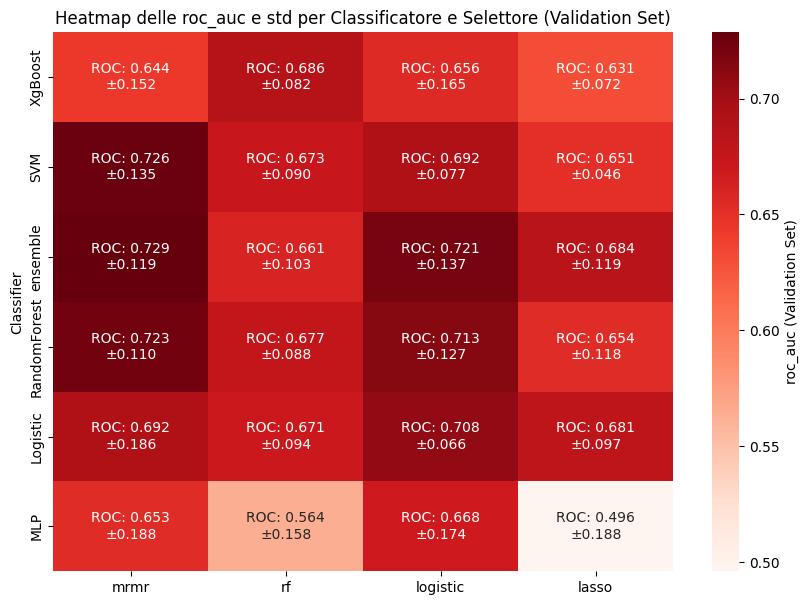

In [283]:
# Inizializza una matrice vuota per memorizzare le performance sul validation set
heatmap_data = pd.DataFrame(index=classifiers, columns=selectors)
annotations = pd.DataFrame(index=classifiers, columns=selectors)


# Popola la matrice con i valori di avg_balaccuracy e annotazioni con std_balaccuracy
for result in best_results_class_selector:
    classifier = result['classifier']
    selector = result['selector']
    
    # Se classifier e selector non sono None, significa che abbiamo un risultato valido
    if classifier is not None and selector is not None:
        # Estrai i valori numerici
        avg_balaccuracy = result[metricaavg]
        std_balaccuracy = result[metricastd]
        
        # Inserisci la balanced accuracy del validation set nella heatmap
        heatmap_data.loc[classifier, selector] = avg_balaccuracy
        
        # Inserisci l'annotazione con la balanced accuracy e la deviazione standard
        annotations.loc[classifier, selector] = (
            f"{labell}: {avg_balaccuracy:.3f}\n"
            f"±{std_balaccuracy:.3f}"
        )

# Riempi i valori NaN con 0 (se necessario)
heatmap_data = heatmap_data.astype(float).fillna(0)

# Crea la heatmap con annotazioni
plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_data, annot=annotations, fmt="", cmap="Reds", cbar_kws={'label': f'{metricanome} (Validation Set)'})
plt.title(f"Heatmap delle {metricanome} e std per Classificatore e Selettore (Validation Set)")
plt.ylabel('Classifier')


### heatmap test

In [280]:
features_fisse=False

if(features_fisse== True):
    best_result_test= best_results_class_selector_test_features_fisse
else:
    best_result_test= best_results_class_selector_test


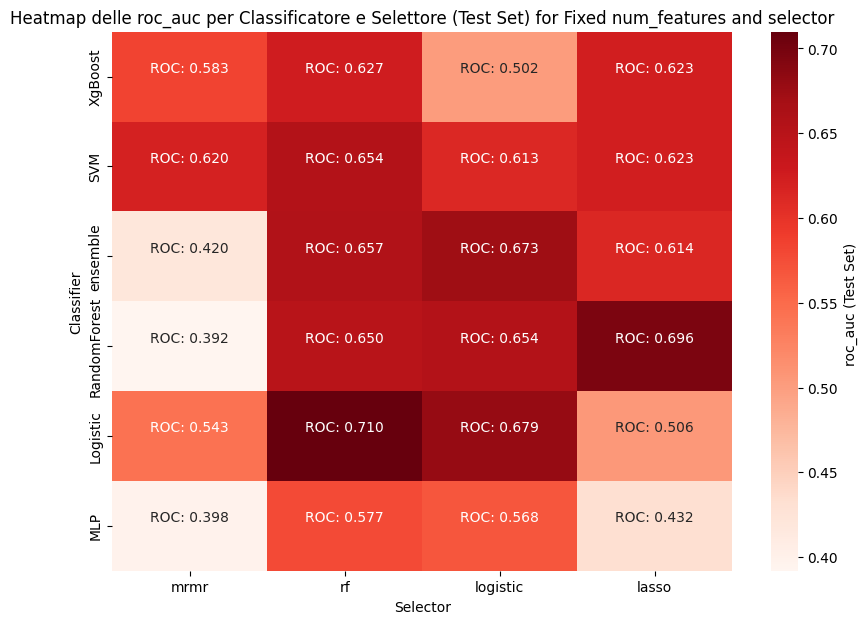

In [284]:

heatmap_data = pd.DataFrame(index=classifiers, columns=selectors)
annotations = pd.DataFrame(index=classifiers, columns=selectors)


for result in best_result_test: ### per features NON FISSE
    classifier = result['classifier']
    selector = result['selector']
    

    if classifier is not None and selector is not None:

        balaccuracy = result[metricanome]

        heatmap_data.loc[classifier, selector] = balaccuracy
        
        # Inserisci l'annotazione con la balanced accuracy, la deviazione standard, il mode e il numero di features
        annotations.loc[classifier, selector] = (
            f"{labell}: {balaccuracy:.3f}\n"
        )

# Riempi i valori NaN con 0 (se necessario)
heatmap_data = heatmap_data.astype(float).fillna(0)


# Crea la heatmap con Balanced Accuracy e annotazioni personalizzate
plt.figure(figsize=(10, 7))

sns.heatmap(heatmap_data, annot=annotations, fmt="", cmap="Reds", cbar_kws={'label': f'{metricanome} (Test Set) '})

if(features_fisse==True):
    plt.title(f"Heatmap delle {metricanome} per Classificatore e Selettore (Test Set) for Fixed Features")
if(features_fisse==False):
    plt.title(f"Heatmap delle {metricanome} per Classificatore e Selettore (Test Set) for Fixed num_features and selector")
plt.ylabel('Classifier')
plt.xlabel('Selector')
plt.show()

## FINETUNAMENTO SEEDs


In [201]:

seeds = list(range(1, 40)) 
print(seeds)


alpha_rad_new = np.linspace(0.0008, 0.1, 50).tolist() ## range per radiomica

alpha_vgg_new = np.linspace(1, 8, 40).tolist() ## RANGE PER VGG

alpha_inc_new = np.linspace(0.055, 0.41, 30).tolist() ## RANGE INCEPETION

alpha_res_new = np.linspace(0.1, 0.5, 30).tolist() ## RANGE resnet


alpha_values=alpha_res_new




thresholds=[0.5]

#selectors=['lasso', 'mrmr','rf', 'logistic']

classifiers=['XgBoost',  'SVM', 'ensemble','RandomForest', 'Logistic', 'MLP']

selectors=['mrmr','rf', 'logistic', 'lasso']


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


In [ ]:
template_dict = {
                #'seedSmote':None,
                'seedKFold': None,
                'fold': None,
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'selected_features': [],
                'balanced accuracy': None
                }


results_val_others = [template_dict.copy() for _ in range(900000)]
results_val_others.append(template_dict.copy())

results_val_lasso = [template_dict.copy() for _ in range(900000)]
results_val_lasso.append(template_dict.copy())

results_test_others = [template_dict.copy() for _ in range(900000)]
results_test_others.append(template_dict.copy())

results_test_lasso = [template_dict.copy() for _ in range(900000)]
results_test_lasso.append(template_dict.copy())

k=0
u=0
n_folds=5

for seed1 in seeds:
        print("Starting with seed ", seed1)
     
     #for seed2 in seeds:
        
        smote = SMOTE(random_state=10)

        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed1)

        for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train_reduced, Y_train)):
            #print("Starting with fold:", fold_idx)

            x_train_reduced, X_val_reduced = X_train_reduced[train_index], X_train_reduced[val_index]
            y_train, y_val = Y_train[train_index], Y_train[val_index]

            x_train_reduced, y_train = smote.fit_resample(x_train_reduced, y_train)

            #X_train_reduced, Y_train = smote.fit_resample(X_train_reduced, Y_train)


            for i, classifier in enumerate(classifiers):
                    #print("Starting with classifier:", classifier)
                    for j, selector in enumerate(selectors):
                        #print("Starting with selector:", selector)

                        if(selector=='lasso'):

                            for alpha in alpha_values:
                                #print("Doing alpha ", alpha )
                                classi= classifierinitialization(classifier)
                                best_case_val= classification_method(selector, classi, alpha, x_train_reduced, y_train, X_val_reduced, y_val, 0, selected_features=[0], thresholds=0.5)
                                
                                if(best_case_val==0 or best_case_val['num_features']> limit):
                                    best_case_val=template_dict
                                    best_case_val['balanced accuracy'] = 0
                                    best_case_val['accuracy'] = 0
                                    best_case_val['f1'] = 0
                                    best_case_val['roc_auc'] = 0
                                    best_case_val['pr_auc'] = 0
                                    best_case_val['selected_features'] = [0]
                                    best_case_val['num_features'] = 0
                                    best_case_val['confusion_matrix'] = 0
                                
                                results_val_lasso[k] = {
                                                    #'seedSmote': seed1,
                                                    'seedKFold': seed1,
                                                    'fold': fold_idx,
                                                    'classifier': classifier,
                                                    'selector': selector,
                                                    'alpha': alpha,
                                                    'num_features': best_case_val['num_features'],
                                                    'selected_features': best_case_val['selected_features'],
                                                    'pr_auc': best_case_val['pr_auc'],
                                                    'roc_auc': best_case_val['roc_auc'],
                                                    'f1': best_case_val['f1'],
                                                    'accuracy': best_case_val['accuracy'],
                                                    'confusion_matrix': best_case_val['confusion_matrix'],
                                                    'balanced accuracy': best_case_val['balanced accuracy'],
                                                    }

                                #print(best_case_val['num_features'])
                                

                                if(fold_idx==0):
                                    classi= classifierinitialization(classifier)
                                    best_case_test= classification_method(selector, classi, alpha, X_train_reduced, Y_train, X_test_reduced, y_test, 0, selected_features=[0], thresholds=0.5)

                                    if(best_case_test==0):
                                        continue
                                    results_test_lasso[u] = {
                                                        #'seedSmote': seed1,
                                                        'seedKFold': seed1,
                                                        'classifier': classifier,
                                                        'selector': selector,
                                                        'alpha': alpha,
                                                        'num_features': best_case_test['num_features'],
                                                        'selected_features': best_case_test['selected_features'],
                                                        'pr_auc': best_case_test['pr_auc'],
                                                        'roc_auc': best_case_test['roc_auc'],
                                                        'f1': best_case_test['f1'],
                                                        'accuracy': best_case_test['accuracy'],
                                                        'confusion_matrix': best_case_test['confusion_matrix'],
                                                        'balanced accuracy': best_case_test['balanced accuracy'],
                                                        }
                                    u=u+1
                                k = k + 1

                        else:
                            #limit=len(x_train_reduced[0]) + 1
                            limit=30
                            for t in range(1, limit):
                                    classi= classifierinitialization(classifier)

                                    best_case_val= classification_method(selector, classi, 0, x_train_reduced, y_train, X_val_reduced, y_val, t, selected_features=[0], thresholds=0.5)
                            
                                        
                                    results_val_others[k] = {
                                                        #'seedSmote': seed1,
                                                        'seedKFold': seed1,
                                                        'fold': fold_idx,
                                                        'classifier': classifier,
                                                        'selector': selector,
                                                        'alpha': 0,
                                                        'num_features': t,
                                                        'selected_features': best_case_val['selected_features'],
                                                        'pr_auc': best_case_val['pr_auc'],
                                                        'roc_auc': best_case_val['roc_auc'],
                                                        'f1': best_case_val['f1'],
                                                        'accuracy': best_case_val['accuracy'],
                                                        'confusion_matrix': best_case_val['confusion_matrix'],
                                                        'balanced accuracy': best_case_val['balanced accuracy'],
                                                        }
                                    #print(results_val_others[k]['f1'])

                                    if(fold_idx==0):
                                        classi= classifierinitialization(classifier)
                                        best_case_test= classification_method(selector, classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, t, selected_features=[0], thresholds=0.5)
                                        
                                        results_test_others[u] = {
                                                            #'seedSmote': seed1,
                                                            'seedKFold': seed1,
                                                            'classifier': classifier,
                                                            'selector': selector,
                                                            'alpha': 0,
                                                            'num_features': t,
                                                            'selected_features': best_case_test['selected_features'],
                                                            'pr_auc': best_case_test['pr_auc'],
                                                            'roc_auc': best_case_test['roc_auc'],
                                                            'f1': best_case_test['f1'],
                                                            'accuracy': best_case_test['accuracy'],
                                                            'confusion_matrix': best_case_test['confusion_matrix'],
                                                            'balanced accuracy': best_case_test['balanced accuracy'],
                                                            }
                                        u=u+1

                                    k = k + 1

In [204]:
results_test_lasso = [entry for entry in results_test_lasso if entry['classifier'] is not None]
results_val_lasso= [entry for entry in results_val_lasso if entry['classifier'] is not None]
results_test_others = [entry for entry in results_test_others if entry['classifier'] is not None]
results_val_others = [entry for entry in results_val_others if entry['classifier'] is not None]

In [206]:
seeds = list(range(1, 15)) 
num_features_range= range(1, limit)
grid_results_others = {}
grid_results_lasso = {}

selectors = ['mrmr', 'rf', 'logistic']

for seed1 in seeds:
        # Itera su tutte le combinazioni di parametri (classifier, selector, num_features, threshold)
        for classifier in classifiers:
                    #print(f"Sto iniziando classifier {classifier}")
                    for selector in selectors:
                            #print(f"Sto iniziando selector {selector}")
                            for num_features in num_features_range:
                                    
                                    # Filtra i risultati che corrispondono a questa combinazione di parametri
                                    filtered_results=[]
                                    for res in results_val_others:
                                        ## qui filtro per num_features
                                        if (res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features and res['seedKFold']== seed1):
                                            filtered_results.append(res)
                                
                                    if filtered_results:
                                        f1_values = [res['f1'] for res in filtered_results]
                                        balaccuracy_values = [res['balanced accuracy'] for res in filtered_results]
                                        roc_values=[res['roc_auc'] for res in filtered_results]

                                        # Calcola le medie delle metriche
                                        avg_f1 = sum(f1_values) / len(f1_values)
                                        avg_balaccuracy = sum(balaccuracy_values) / len(balaccuracy_values)
                                        avg_roc = sum(roc_values) / len(roc_values)

                                        # Calcola la deviazione standard delle metriche
                                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                                        std_balaccuracy = statistics.stdev(balaccuracy_values) if len(balaccuracy_values) > 1 else 0
                                        std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                                        # Memorizza i risultati medi e la deviazione standard di questa combinazione
                                        grid_results_others[(classifier, selector, num_features, seed1)] = {
                                            'avg_f1': avg_f1,
                                            'std_f1': std_f1,
                                            'avg_balaccuracy': avg_balaccuracy,
                                            'std_balaccuracy': std_balaccuracy,
                                            'avg_roc_auc': avg_roc,
                                            'std_roc_auc': std_roc_auc,
                                            #'seedSmote': seed1,
                                            'seedKFold': seed1
                                        }



## ORA PER LASSO
selectors = ['lasso']
for seed1 in seeds:
        for classifier in classifiers:
                    #print(f"Sto iniziando classifier {classifier}")
                    for selector in selectors:
                        #print(f"Sto iniziando selector {selector}")
                        for alpha in alpha_values:
                                filtered_results = []
                                for res in results_val_lasso:
                                    ## qui filtro per alpha
                                    if (res['classifier'] == classifier and res['selector'] == selector and res['alpha'] == alpha and res['seedKFold']== seed1):
                                        filtered_results.append(res)

                                if filtered_results:
                                        f1_values = [res['f1'] for res in filtered_results]
                                        balaccuracy_values = [res['balanced accuracy'] for res in filtered_results]
                                        roc_values=[res['roc_auc'] for res in filtered_results]

                                        # Calcola le medie delle metriche
                                        avg_f1 = sum(f1_values) / len(f1_values)
                                        avg_balaccuracy = sum(balaccuracy_values) / len(balaccuracy_values)
                                        avg_roc = sum(roc_values) / len(roc_values)

                                        # Calcola la deviazione standard delle metriche
                                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                                        std_balaccuracy = statistics.stdev(balaccuracy_values) if len(balaccuracy_values) > 1 else 0
                                        std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                                        # Memorizza i risultati medi e la deviazione standard di questa combinazione
                                        grid_results_lasso[(classifier, selector, alpha, seed1)] = {
                                            'avg_f1': avg_f1,
                                            'std_f1': std_f1,
                                            'avg_balaccuracy': avg_balaccuracy,
                                            'std_balaccuracy': std_balaccuracy,
                                            'avg_roc_auc': avg_roc,
                                            'std_roc_auc': std_roc_auc,
                                            #'seedSmote': seed1,
                                            'seedKFold': seed1
                                        }

In [209]:
# Liste per memorizzare i migliori risultati, con seed inclusi nei valori
best_results_others = []
best_results_lasso = []

# Funzione di confronto che tiene conto prima di "balanced accuracy" e poi di "roc_auc"
def is_better(result1, result2):
    if result1['avg_balaccuracy'] > result2['avg_balaccuracy']:
        return True
    elif result1['avg_balaccuracy'] == result2['avg_balaccuracy']:
        return result1['avg_roc_auc'] > result2['avg_roc_auc']
    return False

# Filtraggio per grid_results_others: scegli il migliore per ogni coppia (seed1, seed2)
for key, result in grid_results_others.items():
    classifier, selector, num_features, seed1 = key
    seed_pair = (seed1)
    
    # Cerca se esiste già una combinazione con la stessa coppia di seed
    found = False
    for entry in best_results_others:
        if (entry['seed1'] == seed1):
            found = True
            # Se esiste, confronta le metriche e tieni il migliore
            if is_better(result, entry):
                entry.update({
                    'classifier': classifier,
                    'selector': selector,
                    'num_features': num_features,
                    'avg_f1': result['avg_f1'],
                    'std_f1': result['std_f1'],
                    'avg_balaccuracy': result['avg_balaccuracy'],
                    'std_balaccuracy': result['std_balaccuracy'],
                    'avg_roc_auc': result['avg_roc_auc'],
                    'std_roc_auc': result['std_roc_auc'],
                    'seed1': seed1,
                })
            break
    
    # Se non esiste, aggiungi la nuova combinazione
    if not found:
        best_results_others.append({
            'classifier': classifier,
            'selector': selector,
            'num_features': num_features,
            'avg_f1': result['avg_f1'],
            'std_f1': result['std_f1'],
            'avg_balaccuracy': result['avg_balaccuracy'],
            'std_balaccuracy': result['std_balaccuracy'],
            'avg_roc_auc': result['avg_roc_auc'],
            'std_roc_auc': result['std_roc_auc'],
            'seed1': seed1,
        })

# Filtraggio per grid_results_lasso: scegli il migliore per ogni coppia (seed1, seed2)
for key, result in grid_results_lasso.items():
    classifier, selector, alpha, seed1 = key
    seed_pair = (seed1)
    
    # Cerca se esiste già una combinazione con la stessa coppia di seed
    found = False
    for entry in best_results_lasso:
        if (entry['seed1'] == seed1):
            found = True
            # Se esiste, confronta le metriche e tieni il migliore
            if is_better(result, entry):
                entry.update({
                    'classifier': classifier,
                    'selector': selector,
                    'alpha': alpha,
                    'avg_f1': result['avg_f1'],
                    'std_f1': result['std_f1'],
                    'avg_balaccuracy': result['avg_balaccuracy'],
                    'std_balaccuracy': result['std_balaccuracy'],
                    'avg_roc_auc': result['avg_roc_auc'],
                    'std_roc_auc': result['std_roc_auc'],
                    'seed1': seed1,
                })
            break
    
    # Se non esiste, aggiungi la nuova combinazione
    if not found:
        best_results_lasso.append({
            'classifier': classifier,
            'selector': selector,
            'alpha': alpha,
            'avg_f1': result['avg_f1'],
            'std_f1': result['std_f1'],
            'avg_balaccuracy': result['avg_balaccuracy'],
            'std_balaccuracy': result['std_balaccuracy'],
            'avg_roc_auc': result['avg_roc_auc'],
            'std_roc_auc': result['std_roc_auc'],
            'seed1': seed1,
        })

# Ora best_results_others e best_results_lasso contengono solo un elemento per ogni coppia di seed (seed1, seed2).


In [42]:
import pickle

# Carica i risultati dal file 'best_results_others_VGG.pkl'
with open('/Users/alessiamenozzi/Desktop/best_results_others_VGG.pkl', 'rb') as f:
    best_results_others = pickle.load(f)

# Carica i risultati dal file 'best_results_lasso_VGG.pkl'
with open('/Users/alessiamenozzi/Desktop/best_results_lasso_VGG.pkl', 'rb') as f:
    best_results_lasso = pickle.load(f)

# Ora puoi utilizzare best_results_others e best_results_lasso come variabili in Python
print(best_results_others)
print(best_results_lasso)


[{'classifier': 'RandomForest', 'selector': 'logistic', 'num_features': 15, 'avg_f1': 0.6634360410830997, 'std_f1': 0.10849057677907298, 'avg_balaccuracy': 0.6808333333333333, 'std_balaccuracy': 0.0996783019964169, 'avg_roc_auc': 0.6881635802469136, 'std_roc_auc': 0.1330111584914087, 'seed1': 1, 'seed2': 1}, {'classifier': 'RandomForest', 'selector': 'mrmr', 'num_features': 14, 'avg_f1': 0.6586687306501549, 'std_f1': 0.09837336461806516, 'avg_balaccuracy': 0.6794444444444444, 'std_balaccuracy': 0.09049333240563384, 'avg_roc_auc': 0.6683950617283949, 'std_roc_auc': 0.17236679943614014, 'seed1': 1, 'seed2': 2}, {'classifier': 'ensemble', 'selector': 'rf', 'num_features': 23, 'avg_f1': 0.690531475748194, 'std_f1': 0.14285195679719967, 'avg_balaccuracy': 0.6947222222222222, 'std_balaccuracy': 0.14424866539810965, 'avg_roc_auc': 0.7208641975308643, 'std_roc_auc': 0.16073852873210123, 'seed1': 1, 'seed2': 3}, {'classifier': 'ensemble', 'selector': 'logistic', 'num_features': 7, 'avg_f1': 0.6

In [212]:
u=0
results_test_others = [template_dict.copy() for _ in range(9000)]
results_test_others.append(template_dict.copy())

results_test_lasso = [template_dict.copy() for _ in range(9000)]
results_test_lasso.append(template_dict.copy())

for res in best_results_lasso:
    classi= classifierinitialization(res['classifier'])
    best_case_test= classification_method(res['selector'], classi, res['alpha'], X_train_reduced, Y_train, X_test_reduced, y_test, 0, selected_features=[0], thresholds=0.5)

    if(best_case_test==0):
        continue
    results_test_lasso[u] = {
                                                            #'seedSmote': res['seed1'],
                                                            'seedKFold': res['seed1'],
                                                            'classifier': res['classifier'],
                                                            'selector': res['selector'],
                                                            'alpha': res['alpha'],
                                                            'num_features': best_case_test['num_features'],
                                                            'selected_features': best_case_test['selected_features'],
                                                            'pr_auc': best_case_test['pr_auc'],
                                                            'roc_auc': best_case_test['roc_auc'],
                                                            'f1': best_case_test['f1'],
                                                            'accuracy': best_case_test['accuracy'],
                                                            'confusion_matrix': best_case_test['confusion_matrix'],
                                                            'balanced accuracy': best_case_test['balanced accuracy'],
                                                            }
    u=u+1

In [214]:
u=0
for res in best_results_others:
    classi= classifierinitialization(res['classifier'])
    best_case_test= classification_method(res['selector'], classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, res['num_features'], selected_features=[0], thresholds=0.5)

    if(best_case_test==0):
        continue
    results_test_others[u] = {
                                                            #'seedSmote': res['seed1'],
                                                            'seedKFold': res['seed1'],
                                                            'classifier': res['classifier'],
                                                            'selector': res['selector'],
                                                            'alpha': 0,
                                                            'num_features': res['num_features'],
                                                            'selected_features': best_case_test['selected_features'],
                                                            'pr_auc': best_case_test['pr_auc'],
                                                            'roc_auc': best_case_test['roc_auc'],
                                                            'f1': best_case_test['f1'],
                                                            'accuracy': best_case_test['accuracy'],
                                                            'confusion_matrix': best_case_test['confusion_matrix'],
                                                            'balanced accuracy': best_case_test['balanced accuracy'],
                                                            }
    u=u+1

In [216]:
s=0

print(f"Combinazioni con balanced accuracy > 0.7 sul test set:")

# Itera su tutte le migliori combinazioni trovate nei risultati di validazione di 'others'
for i, result in enumerate(best_results_others, start=1):
    best_case = None  # Inizializza best_case
    # Cerca la combinazione corrispondente nei risultati del test set 'others'
    for p in range(len(results_test_others)):
        if (results_test_others[p]['classifier'] == result['classifier'] and
            results_test_others[p]['selector'] == result['selector'] and
            results_test_others[p]['num_features'] == result['num_features'] and
            results_test_others[p]['seedKFold'] == result['seed1']):
            #results_test_others[p]['seedSmote'] == result['seed1']):
            
            best_case = results_test_others[p]
            break
    
    # Controlla se la balanced accuracy sul test è maggiore di 0.7
    if best_case and best_case['balanced accuracy'] > 0.7:
        s=s+1
        print(f"\n#{s}:")
        print(f"Classifier: {result['classifier']}")
        print(f"Selector: {result['selector']}")
        print(f"Num_features: {result['num_features']}")
        print(f"Seed Kfold: {result['seed1']}")
        #print(f"Seed Smote: {result['seed1']}")
        
        # Stampa le performance medie dal validation set
        print(f"Performance medie sul validation set: \nROC AUC = {result['avg_roc_auc']} (std = {result['std_roc_auc']}), "
              f"Balanced Accuracy = {result['avg_balaccuracy']} (std = {result['std_balaccuracy']})")
        
        # Stampa le metriche sul test set
        print("Metrics on the TEST set:")
        print(f"Selected Features: {best_case['selected_features']}")
        print(f"ROC AUC: {best_case['roc_auc']}")
        print(f"F1 Score: {best_case['f1']}")
        print(f"Accuracy: {best_case['accuracy']}")
        print(f"Balanced Accuracy: {best_case['balanced accuracy']}")
        print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")



Combinazioni con balanced accuracy > 0.7 sul test set:

#1:
Classifier: RandomForest
Selector: logistic
Num_features: 25
Seed Kfold: 4
Performance medie sul validation set: 
ROC AUC = 0.829429012345679 (std = 0.11045898090090925), Balanced Accuracy = 0.7697222222222223 (std = 0.1224760621610163)
Metrics on the TEST set:
Selected Features: [ 32 149 202 143 290  22  93 227 193 176 163 231  56 228 115 112 266 118
 164  43  38 204 220 196 179]
ROC AUC: 0.7453703703703705
F1 Score: 0.625
Accuracy: 0.6923076923076923
Balanced Accuracy: 0.7314814814814815
Confusion Matrix: 
[[17 10]
 [ 2 10]]

#2:
Classifier: RandomForest
Selector: logistic
Num_features: 25
Seed Kfold: 9
Performance medie sul validation set: 
ROC AUC = 0.783148148148148 (std = 0.0582582832174368), Balanced Accuracy = 0.7694444444444445 (std = 0.06276179737608335)
Metrics on the TEST set:
Selected Features: [ 32 149 202 143 290  22  93 227 193 176 163 231  56 228 115 112 266 118
 164  43  38 204 220 196 179]
ROC AUC: 0.7453703

In [54]:

# Itera su tutte le migliori combinazioni trovate nei risultati di validazione di 'lasso'
for i, result in enumerate(best_results_lasso, start=len(best_results_others) + 1):
    best_case = None  # Inizializza best_case
    # Cerca la combinazione corrispondente nei risultati del test set 'lasso'
    for p in range(len(results_test_lasso)):
        if (results_test_lasso[p]['classifier'] == result['classifier'] and
            results_test_lasso[p]['alpha'] == result['alpha'] and
            results_test_lasso[p]['seedKFold'] == result['seed1'] and
            results_test_lasso[p]['seedSmote'] == result['seed2']):
            
            best_case = results_test_lasso[p]
            break
    
    # Controlla se la balanced accuracy sul test è maggiore di 0.7
    if best_case and best_case['balanced accuracy'] > 0.7:
        s=s+1
        print(f"\n#{s}:")
        print(f"Classifier: {result['classifier']}")
        print(f"Selector: {result['selector']}")
        print(f"Alpha: {result['alpha']}")
        print(f"Seed Kfold: {result['seed1']}")
        print(f"Seed Smote: {result['seed2']}")
        
        # Stampa le performance medie dal validation set
        print(f"Performance medie sul validation set: \nROC AUC = {result['avg_roc_auc']} (std = {result['std_roc_auc']}), "
              f"Balanced Accuracy = {result['avg_balaccuracy']} (std = {result['std_balaccuracy']})")
        
        # Stampa le metriche sul test set
        print("Metrics on the TEST set:")
        print(f"Selected Features: {best_case['selected_features']}")
        print(f"ROC AUC: {best_case['roc_auc']}")
        print(f"F1 Score: {best_case['f1']}")
        print(f"Accuracy: {best_case['accuracy']}")
        print(f"Balanced Accuracy: {best_case['balanced accuracy']}")
        print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")



#16:
Classifier: ensemble
Selector: lasso
Alpha: 0.19275862068965519
Seed Kfold: 1
Seed Smote: 1
Performance medie sul validation set: 
ROC AUC = 0.7151851851851851 (std = 0.1769195260280399), Balanced Accuracy = 0.6852777777777778 (std = 0.14257808668399616)
Metrics on the TEST set:
Selected Features: [ 0  3  4  5  6  7  8  9 10 11 13 15 16 17 18 19 20 21 22 23 25 28 29 32
 33 35 36 37 38 39 40 41]
ROC AUC: 0.6666666666666667
F1 Score: 0.6
Accuracy: 0.6923076923076923
Balanced Accuracy: 0.7083333333333333
Confusion Matrix: 
[[18  9]
 [ 3  9]]

#17:
Classifier: RandomForest
Selector: lasso
Alpha: 0.4487931034482759
Seed Kfold: 6
Seed Smote: 6
Performance medie sul validation set: 
ROC AUC = 0.7691203703703703 (std = 0.08099563168799735), Balanced Accuracy = 0.7155555555555555 (std = 0.10439050025366232)
Metrics on the TEST set:
Selected Features: [ 0  4  5  8 11 13 15 17 18 19 20 21 22 23 24 25 29 30 33 34 37 38 39 40
 41]
ROC AUC: 0.6712962962962963
F1 Score: 0.6
Accuracy: 0.69230769

In [17]:
import pickle

# Salva i risultati in un file pickle
with open('/Users/alessiamenozzi/Desktop/best_results_others_VGG.pkl', 'wb') as f:
    pickle.dump(best_results_others, f)

with open('/Users/alessiamenozzi/Desktop/best_results_lasso_VGG.pkl', 'wb') as f:
    pickle.dump(best_results_lasso, f)


## Fine Tuning Threshold su risultati migliori

In [413]:
n_folds=5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=13)

thresholds=np.arange(0.3, 0.71, 0.01)
#thresholds=[0.5]

classifier='SVM'
selector='logistic'
num_features=2
alpha= 0.13206896551724137

template_dict = {
                'fold': None,
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'threshold': None,
                'selected_features': [],
                'balanced accuracy': None
            }

## creazione di dizionari vuoti (range con numero elevato casuale)
results_val_2_others = [template_dict.copy() for _ in range(3000)]
results_val_2_others.append(template_dict.copy())


smote = SMOTE(random_state=10)

k=0
old_count = 0
for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train_reduced, Y_train)):
    print("Starting with fold:", fold_idx)

    x_train_reduced, X_val_reduced = X_train_reduced[train_index], X_train_reduced[val_index]
    y_train, y_val = Y_train[train_index], Y_train[val_index]

    x_train_reduced, y_train = smote.fit_resample(x_train_reduced, y_train)

    classi=classifierinitialization(classifier)
                    
    y_proba_test, number_features, selected_features = classification_method_withoutThreshold(selector, classi, 0, x_train_reduced, y_train, X_val_reduced, y_val, num_features=num_features, mode="Val", selected_features=[0])

    best_f1_val = -1
    best_threshold_val = 0
    best_case_val = None
                        
    for threshold in thresholds:
            
        best_case_val = classification_threshold(y_proba_test, y_val, threshold, 0, num_features, selected_features)
                                
        if best_case_val:
            results_val_2_others[k] = {
                                    'fold': fold_idx,
                                    'alpha': 0,
                                    'num_features': num_features,
                                    'selected_features': best_case_val['selected_features'],
                                    'roc_auc': best_case_val['roc_auc'],
                                    'f1': best_case_val['f1'],
                                    'accuracy': best_case_val['accuracy'],
                                    'confusion_matrix': best_case_val['confusion_matrix'],
                                    'threshold': threshold, 
                                    'balanced accuracy': best_case_val['balanced accuracy']
                                }
            k = k + 1
                        

Starting with fold: 0
Starting with fold: 1
Starting with fold: 2
Starting with fold: 3
Starting with fold: 4


In [414]:
#num_features_range = list(range(1, (len(x_train_reduced[0]) + 1)))
num_features_range=list(range(1,30))

grid_results_others = {}
grid_results_lasso = {}



for threshold in thresholds:
                    # Filtra i risultati che corrispondono a questa combinazione di parametri
                    filtered_results=[]
                    for res in results_val_2_others:
                        if (res['threshold'] == threshold):
                            filtered_results.append(res)
                
                    if filtered_results:
                        f1_values = [res['f1'] for res in filtered_results]
                        balaccuracy_values = [res['balanced accuracy'] for res in filtered_results]
                        roc_values=[res['roc_auc'] for res in filtered_results]

                        # Calcola le medie delle metriche
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_balaccuracy = sum(balaccuracy_values) / len(balaccuracy_values)
                        avg_roc = sum(roc_values) / len(roc_values)

                        # Calcola la deviazione standard delle metriche
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_balaccuracy = statistics.stdev(balaccuracy_values) if len(balaccuracy_values) > 1 else 0
                        std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                        # Memorizza i risultati medi e la deviazione standard di questa combinazione
                        grid_results_others[(threshold)] = {
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_balaccuracy': avg_balaccuracy,
                            'std_balaccuracy': std_balaccuracy,
                            'avg_roc_auc': avg_roc,
                            'std_roc_auc': std_roc_auc
                        }

# Ordina le combinazioni per 'avg_f1', e in caso di parità, per 'avg_pr_auc'
sorted_results_2 = sorted(grid_results_others.items(), key=lambda x: (x[1]['avg_balaccuracy'], x[1]['avg_roc_auc']),reverse=True)


In [415]:
n=10
best_combinations = sorted_results_2[:n] ## mostrando le n migliori configurazioni

print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_combinations, start=1):
    print(f"\n#{i}:")
    print(f"Classifier: {classifier}")
    print(f"Selector: {selector}")
    if (selector=='lasso'):
        print(f"Alpha: {alpha}")
    print(f"Num_features: {num_features}")
    print(f"Threshold: {params}")
    #print(f"Threshold: {params[3]}")

    print(f"Performance medie sul val set: \nF1 = {metrics['avg_f1']} (std = {metrics['std_f1']}), "f"ROC AUC = {metrics['avg_roc_auc']} (std = {metrics['std_roc_auc']}), "f"Balanced Accuracy = {metrics['avg_balaccuracy']} (std = {metrics['std_balaccuracy']})")

    
    classi=classifierinitialization(classifier)

    if(selector=='lasso'):     
        best_case=classification_method(selector, classi, alpha, X_train_reduced, Y_train, X_test_reduced, y_test, 0, mode="Val", selected_features=[0], thresholds=params)
    else: 
        best_case=classification_method(selector, classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, num_features, mode="Val", selected_features=[0], thresholds=params)


    print("Metrics on the TEST set:")

   
    print(f"Threshold: {best_case['best_threshold']}")
    print(f"Selected Features: {best_case['selected_features']}")
    print(f"ROC AUC: {best_case['roc_auc']}")
    print(f"F1 Score: {best_case['f1']}")
    print(f"Accuracy: {best_case['accuracy']}")
    print(f"Balanced Accuracy: {best_case['balanced accuracy']}")
    print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")


Migliori 10 combinazioni di parametri:

#1:
Classifier: SVM
Selector: logistic
Num_features: 2
Threshold: 0.47000000000000014
Performance medie sul val set: 
F1 = 0.7444552557865252 (std = 0.0874181145450047), ROC AUC = 0.741851851851852 (std = 0.07406293318997252), Balanced Accuracy = 0.7394444444444443 (std = 0.10521051061186748)
Metrics on the TEST set:
Threshold: 0.47000000000000014
Selected Features: [19 17]
ROC AUC: 0.7376543209876543
F1 Score: 0.6
Accuracy: 0.6923076923076923
Balanced Accuracy: 0.7083333333333333
Confusion Matrix: 
[[18  9]
 [ 3  9]]

#2:
Classifier: SVM
Selector: logistic
Num_features: 2
Threshold: 0.48000000000000015
Performance medie sul val set: 
F1 = 0.7382633053221289 (std = 0.08917106386417038), ROC AUC = 0.741851851851852 (std = 0.07406293318997252), Balanced Accuracy = 0.7369444444444444 (std = 0.10541657517197027)
Metrics on the TEST set:
Threshold: 0.48000000000000015
Selected Features: [19 17]
ROC AUC: 0.7376543209876543
F1 Score: 0.6
Accuracy: 0.692